In [35]:
# All our imports
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import emoji
from emoji_translate.emoji_translate import Translator
import advertools as adv
import regex as re
import pandas as pd


In [36]:
# Initalizes a base directory
base_direct = "archive_og"

In [37]:
# Initalizes our VGG16 model
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [38]:
# Preprocessing each image
features = {}
directory = os.path.join(base_direct, "Images")

for img_name in os.listdir(directory):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

In [40]:
# Opens the caption file
with open(os.path.join(base_direct, "captions.txt")) as file:
    next(file)
    captions_doc = file.read()

# Seperate the image id from the caption and adds it to the mapping dictionary
mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
print(f"Total Amount of Images: {len(mapping)}")

Total Amount of Images: 8091


In [41]:
# Cleans the captions
def clean(mapping):
    for id, captions in mapping.items():
        for x in range(len(captions)):
            caption = captions[x]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = " ".join(caption.split())
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[x] = caption

In [42]:
# Creates a list of all the captions
all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

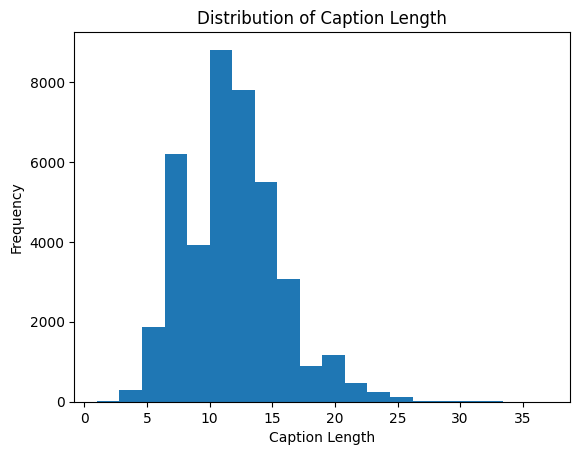

In [43]:
# Get the length of each caption in all_cap and plots the distribution
caption_lengths = [len(caption.split()) for caption in all_cap]

plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Length')
plt.show()


In [44]:
# Use tokenizer function break down captions into individual words and takes vocab size of data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab_size = len(tokenizer.word_index) + 1

In [45]:
# Counts the frequency of unique words and creates an ordered list of the most frequent words
word_freq = Counter(tokenizer.word_counts)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

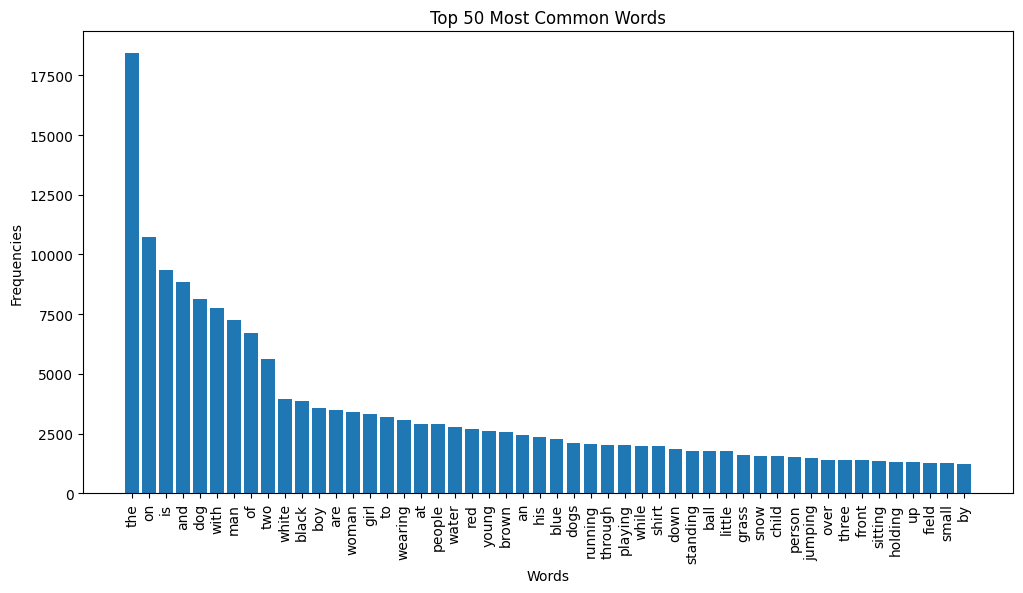

In [46]:

# Separate the words and their frequencies
words, frequencies = zip(*sorted_word_freq[2:52])

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Top 50 Most Common Words')
plt.show()

In [47]:

_, total_frequencies = zip(*sorted_word_freq)
frequencies_top_50 = total_frequencies[2:52]
total_frequency_top_50 = sum(frequencies_top_50)
total_frequency = sum(total_frequencies[2:])
print(total_frequency_top_50)
print(total_frequency)


173398
355645


In [48]:
# Separate the words and their frequencies
words, frequencies = zip(*sorted_word_freq[-20:])
df = pd.DataFrame(words)
df_transposed = df.transpose()
df_transposed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,slat,driftrood,sunlit,consumer,bodysurfs,ever,since,started,pinball,keffiyahs,swatting,containig,rainstorm,breezeway,cocker,spaniels,weight,majestically,scrolled,patterns


In [49]:
# Create a dataframe with sorted_word_freq and filters the dataframe to only include words with one occurence
df = pd.DataFrame(sorted_word_freq, columns=['Word', 'Frequency'])
df_filtered = df[df['Frequency'] == 1]
print(f'Count of Unique Words: {len(df_filtered)}')

Count of Unique Words: 3337


In [50]:
# Finds maximum length of characters in a caption
max_length = max(len(caption.split()) for caption in all_cap)
print(f'Maximum length of characters in a caption: {max_length}')

Maximum length of characters in a caption: 37


In [51]:
# Train test split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.05, random_state = 10)

In [52]:
# Getting batch for sequence to sequence model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for c in captions:
                seq = tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [546]:
# Trains the model
epochs = 100
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

240/240 [==============================] - 92s 383ms/step - loss: 1.3986


In [547]:
# Saves the model
model.save('./best_model.keras')

In [548]:
# Creates a function to convert the index to a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [549]:
# Created a function to predict the caption of an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [550]:
# loads the model
new_model = load_model('./best_model.keras')

In [552]:
# Creates a function that generates the predicted caption and displays both the actual and predicted caption
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_direct, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("-----------Original Descriptions of the Image-----------")
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(new_model, features[image_id], tokenizer, max_length)
    print("-----------Predicted Description of the Image-----------")
    print(y_pred)
    plt.imshow(image)
    return y_pred

-----------Original Descriptions of the Image-----------
a group of people are crossing a river
A group of people are wading though a stream between steep rocky cliffs .
People wading in a river .
Several people are wading in a river in a deep gorge .
Several people wading in the water at the bottom of a ravine .
-----------Predicted Description of the Image-----------
startseq rock climber in a red shirt and another man in a red shirt are climbing on rocks and looking at dropping the rock in the red jacket watching him dropping from below dropping dropping from a rock


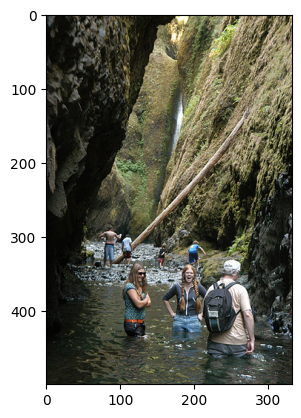

In [599]:
# Tests captions
testing = test[120]
caption_tested = generate_caption(testing + ".jpg")

In [594]:
# Add all caption words to all_cap_and_test and makes the caption lowercase
caption_words = ' '.join(caption_tested.split()[1:-1])
all_cap_and_test = all_cap.copy()
all_cap_and_test.append(caption_words)
all_cap_lower = [x.lower() for x in all_cap_and_test]
print(all_cap_lower[-1])

two dogs are urinating on the same stick in the grass while a white dog watches from the other way the other way through the grass in a wooded area behind the trees is falling off


In [595]:
# Creates a list with the words in the caption
arr = []
arr = all_cap_lower[-1].split(" ")
print(arr)

['two', 'dogs', 'are', 'urinating', 'on', 'the', 'same', 'stick', 'in', 'the', 'grass', 'while', 'a', 'white', 'dog', 'watches', 'from', 'the', 'other', 'way', 'the', 'other', 'way', 'through', 'the', 'grass', 'in', 'a', 'wooded', 'area', 'behind', 'the', 'trees', 'is', 'falling', 'off']


In [596]:
tfid_vec = TfidfVectorizer()
X = tfid_vec.fit_transform(all_cap_lower)

In [597]:
# Removes unneeded endings for words and makes exceptions for certain words
emojii = Translator(exact_match_only = False, randomize = True)
cap_vocab = tfid_vec.get_feature_names_out()[np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word.endswith("ss"):
        cap_vocab[i] = word
    else:
        if word.endswith("s"):
            cap_vocab[i] = word[:-1] 
    if word.endswith("es"):
        cap_vocab[i] = word[:-1]
    elif word.endswith("ing"):
        cap_vocab[i] = word[:-3]
    elif word.endswith("ed"):
        if word == "red":
            break
        cap_vocab[i] = word[:-2]
    elif word == "boy":
        break
    
print(cap_vocab)

['are' 'area' 'behind' 'dog' 'dog' 'fall' 'from' 'grass' 'in' 'i' 'off'
 'on' 'other' 'same' 'stick' 'the' 'through' 'tree' 'two' 'urinat'
 'watche' 'way' 'while' 'white' 'wood']


In [598]:
# Modifies colors to be identified as certain heart emojis and emojifies words that corresponds with emojis
colors = ["red", "orange", "yellow", "green", "blue", "purple", "white", "black", "brown"]
caption_emoji = []
for word in cap_vocab:
    if word in colors:
        if word == "red":
            word = emoji.emojize(":heart:")
        else:
            word = emoji.emojize(":" + word +"_heart:")
    caption_emoji.append(emojii.emojify(word))

print(caption_emoji)

['are', 'area', 'behind', '🐶', '🐶', '🌻', 'from', '🌿', 'in', 'i', 'off', 'on', 'other', 'same', '🥍', 'the', 'through', '🍃', 'two', 'urinat', 'watche', '↕️', 'while', '🤍', 'wood']


In [589]:
# Removes non emojified words and removes emoji unicode
copy_caption_emoji = caption_emoji.copy()

for i, word in enumerate(caption_emoji):
    graphemes =re.findall(r'\X', word)
    result = "".join([grapheme for grapheme in graphemes if re.match(r'^\p{Emoji}(\uFE0F\u20E3?|[\p{Emoji}\u200D])*$', grapheme)])
    copy_caption_emoji[i] = result

while "" in copy_caption_emoji:
    copy_caption_emoji.remove("")

print(copy_caption_emoji)

['💙', '🎓', '🤣', '👧', '💂', '🎱']


In [590]:
# creates a dictionary containing the emojified words and their calculated weights
dic = {}
cap_weights = X.toarray()[-1][np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word not in caption_emoji:
        dic[word] = cap_weights[i]


print(dic)
print(list(dic.keys()))

{'blue': 0.4375006842882488, 'cap': 0.1770469194020557, 'floor': 0.18364382812384222, 'girl': 0.09864376397196556, 'guy': 0.20160015625156524, 'pool': 0.42567733337654495}
['blue', 'cap', 'floor', 'girl', 'guy', 'pool']


In [591]:
# 
def pick_closest_values(arr):
    dict = {}
    for x in range(len(arr)):
        dict[list(arr.values())[x]] = x
    closest_values = sorted(dict.keys(), reverse = False)
    closest_indexes = []
    if len(arr) == 1:
        ret = [0,0,0]
        return ret
    if len(arr) == 2:
        ret = [0,1,0]
        return ret
    for x in range(len(closest_values[:3])):
        closest_indexes.append(dict[closest_values[x]])
    return closest_indexes

👧 🎓 🤣


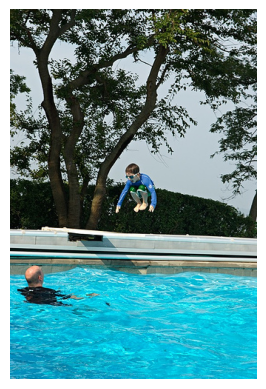

In [592]:
# Get indices of the choosen words and returns the emojis
top_indexes = pick_closest_values(dic)

top_words = []
for x in top_indexes:
    copy_caption_emoji[x] = copy_caption_emoji[x].split("\u200d")[0]
    top_words.append(copy_caption_emoji[x])
image_id = testing.split('.')[0]
img_path = os.path.join(base_direct, "Images", str(testing) + ".jpg")
image = Image.open(img_path)
string = " ".join(map(str, top_words))

print(string)
plt.imshow(image)
plt.axis("off")
plt.show()